# Loan Repayment Challenge
##**Tan Peng Rong**<br>
##**Approx time spend: 30 hours**<br>
To ensure a structured workflow, this assessment is presented in two separate reports.<br><br>

1_preprocessing.html / preprocessing.ipynb covers data exploration, cleaning, preprocessing, and feature selection.<br><br>

2_model_building.html / model_building.ipynb covers model development, training, evaluation, and interpretation of results.
Both reports include detailed explanations of each step taken throughout the analysis and modeling processes.<br><br>

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor as KNN
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

#load datasets

In [ ]:
# load datasets
loan_df = pd.read_csv("loan.csv")
underwriting_df = pd.read_csv("clarity_underwriting_variables.csv", low_memory=False)
payment_df = pd.read_csv("payment.csv")

In [ ]:
# shape
print(f"loan_df shape: {loan_df.shape}")
print(f"payment_df shape: {payment_df.shape}")
print(f"underwriting_df shape: {underwriting_df.shape}")

loan_df shape: (577682, 19)
payment_df shape: (689364, 9)
underwriting_df shape: (49752, 54)


#Laon Dataset Preprocess

In [ ]:
loan_df.head()

,loanId,anon_ssn,payFrequency,apr,applicationDate,originated,originatedDate,nPaidOff,approved,isFunded,loanStatus,loanAmount,originallyScheduledPaymentAmount,state,leadType,leadCost,fpStatus,clarityFraudId,hasCF
0,LL-I-07399092,beff4989be82aab4a5b47679216942fd,B,360.0,2016-02-23T17:29:01.940000,False,NaN,0.0,False,0,Withdrawn Application,500.0,978.27,IL,bvMandatory,6,NaN,5669ef78e4b0c9d3936440e6,1
1,LL-I-06644937,464f5d9ae4fa09ece4048d949191865c,B,199.0,2016-01-19T22:07:36.778000,True,2016-01-20T15:49:18.846000,0.0,True,1,Paid Off Loan,3000.0,6395.19,CA,prescreen,0,Checked,569eb3a3e4b096699f685d64,1
2,LL-I-10707532,3c174ae9e2505a5f9ddbff9843281845,B,590.0,2016-08-01T13:51:14.709000,False,NaN,0.0,False,0,Withdrawn Application,400.0,1199.45,MO,bvMandatory,3,NaN,579eab11e4b0d0502870ef2f,1
3,LL-I-02272596,9be6f443bb97db7e95fa0c281d34da91,B,360.0,2015-08-06T23:58:08.880000,False,NaN,0.0,False,0,Withdrawn Application,500.0,1074.05,IL,bvMandatory,3,NaN,555b1e95e4b0f6f11b267c18,1
4,LL-I-09542882,63b5494f60b5c19c827c7b068443752c,B,590.0,2016-06-05T22:31:34.304000,False,NaN,0.0,False,0,Rejected,350.0,814.37,NV,bvMandatory,3,NaN,5754a91be4b0c6a2bf424772,1


In [ ]:
loan_df.describe()

,apr,nPaidOff,isFunded,loanAmount,originallyScheduledPaymentAmount,leadCost,hasCF
count,573760.000000,577658.000000,577682.000000,575432.000000,577682.000000,577682.000000,577682.000000
mean,553.080972,0.037887,0.067480,514.245084,1428.897209,7.854389,0.619187
std,110.046159,0.333366,0.250852,320.939929,925.009141,12.853451,0.485587
min,0.000000,0.000000,0.000000,0.000000,-816.710000,0.000000,0.000000
25%,490.000000,0.000000,0.000000,350.000000,1023.640000,3.000000,0.000000
50%,590.000000,0.000000,0.000000,500.000000,1245.250000,3.000000,1.000000
75%,601.000000,0.000000,0.000000,500.000000,1615.660000,6.000000,1.000000
max,705.590000,21.000000,1.000000,5000.000000,19963.630000,200.000000,1.000000


**Information from describtion table**
- 75% of nPaidOff is 0, means most of the applicants have not previus paid off loan.
- 75% of isFunded is 0 shows most of the loans are not successfuly processed
- loanAmount show most of them are in the range of 350-500.
- the nagative value of min for originally scheduled payment amount maybe a typo or system error.
- loanAmount, originallyScheduledPaymentAmount, and leadCost have extremly large values/outliers. This may cause right skewed.

##Filter only useful records and features for risk prediction modeling

In [ ]:
loan_df = loan_df[loan_df['isFunded']==1]

In [ ]:
loan_df['loanStatus'].unique()

array(['Paid Off Loan', 'New Loan', 'Internal Collection',
       'External Collection', 'Returned Item', 'Pending Paid Off',
       'Charged Off Paid Off', 'Settled Bankruptcy',
       'Settlement Paid Off', 'Charged Off',
       'Settlement Pending Paid Off'], dtype=object)

In [ ]:
loan_df = loan_df[~loan_df['loanStatus'].isin(['New Loan', 'Returned Item', 'Pending Paid Off', 'Settlement Pending Paid Off'])]
loan_df.drop(columns=['fpStatus','originated','approved','isFunded','originatedDate'], axis=1, inplace=True)

In [ ]:
loan_df['loanStatus'].unique()

array(['Paid Off Loan', 'Internal Collection', 'External Collection',
       'Charged Off Paid Off', 'Settled Bankruptcy',
       'Settlement Paid Off', 'Charged Off'], dtype=object)

In [ ]:
loan_df.head()

,loanId,anon_ssn,payFrequency,apr,applicationDate,nPaidOff,loanStatus,loanAmount,originallyScheduledPaymentAmount,state,leadType,leadCost,clarityFraudId,hasCF
1,LL-I-06644937,464f5d9ae4fa09ece4048d949191865c,B,199.0,2016-01-19T22:07:36.778000,0.0,Paid Off Loan,3000.0,6395.19,CA,prescreen,0,569eb3a3e4b096699f685d64,1
47,LL-I-16519347,bc9fa73468acf18cb968a3a6a3c4697c,S,490.0,2017-01-31T17:48:17.381000,2.0,Paid Off Loan,1250.0,3313.78,MO,organic,0,58450a15e4b0bb9d6d7344c7,1
54,LL-I-11506719,10cefd11d41612b032fd9cd2debe32dc,B,590.0,2016-08-27T09:08:05.442000,0.0,Paid Off Loan,800.0,2432.08,CA,bvMandatory,10,578f9346e4b0810ad5e7b72e,1
64,LL-I-09279047,1d249e27292d25e4d3b4bc142a2a4aea,W,404.1,2016-05-25T03:05:18.849000,3.0,Paid Off Loan,300.0,422.64,WI,organic,0,56621584e4b0100e84141586,1
83,LL-I-18297678,bc500677542783c43842d54e34830f08,B,315.0,2017-03-12T18:24:46.356000,2.0,Internal Collection,1500.0,2875.27,IL,organic,0,579101e7e4b0810ad80e43aa,1


Drop the loan records with not funded because the loan never start to process.
And drop the loanStatus of new, pending, and returned because there are unkown outcome.

The features 'originated', 'approved', 'isFunded', 'originatedDate' are no meaning for the loan risk prediction model

The fpStatus is meaningful but can not include in the risk prediction model because we dont know the first payment status for a new customer before the loan processed.

In [ ]:
loan_df.describe()

,apr,nPaidOff,loanAmount,originallyScheduledPaymentAmount,leadCost,hasCF
count,29518.000000,29497.000000,29518.000000,29518.000000,29518.000000,29518.000000
mean,528.107006,0.348917,619.451707,1691.471815,11.553561,0.830713
std,117.386188,1.019490,460.187799,1221.403110,21.543094,0.375011
min,0.000000,0.000000,100.000000,187.620000,0.000000,0.000000
25%,449.990000,0.000000,350.000000,1010.120000,0.000000,1.000000
50%,590.000000,0.000000,500.000000,1305.380000,3.000000,1.000000
75%,590.000000,0.000000,700.000000,1926.180000,10.000000,1.000000
max,705.590000,21.000000,4687.000000,16800.120000,200.000000,1.000000


**information after filtering**
- all is funded loan
- most originallyScheduledPaymentAmount in range of 1000-2000
- the nagative value in originally shceduled payment amount had been removed
- loanAmount, originallyScheduledPaymentAmount, leadCost outliers still there

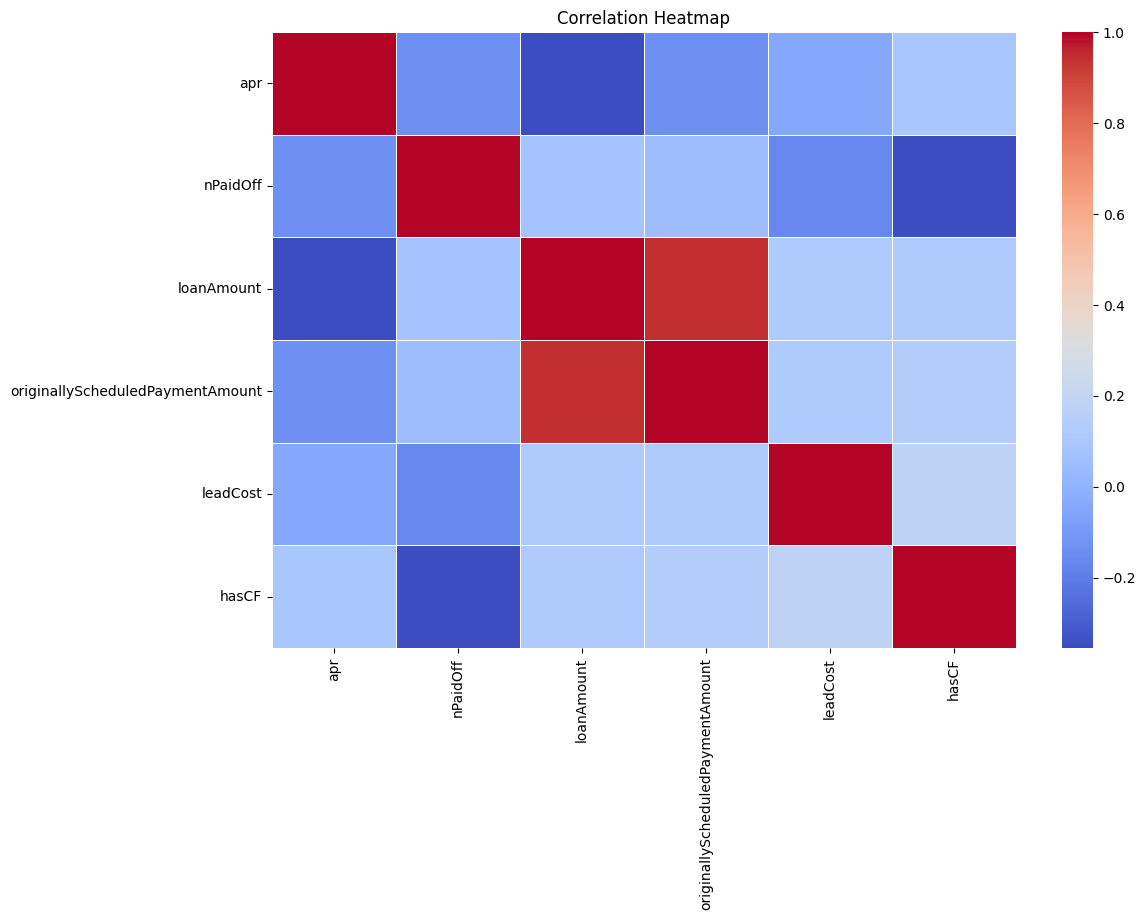

In [ ]:
numeric_df = loan_df.select_dtypes(include=['int64', 'float64'])
plt.figure(figsize=(12,8))
sns.heatmap(numeric_df.corr(), annot=False, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()


**only high relationship between loanAmount and orriginallyScheduledPaymentAmount**

In [ ]:
print(f"loan_df:\n{loan_df.dtypes}")

loan_df:
loanId                               object
anon_ssn                             object
payFrequency                         object
apr                                 float64
applicationDate                      object
nPaidOff                            float64
loanStatus                           object
loanAmount                          float64
originallyScheduledPaymentAmount    float64
state                                object
leadType                             object
leadCost                              int64
clarityFraudId                       object
hasCF                                 int64
dtype: object


In [ ]:
# transform dates into date type
loan_df['applicationDate'] = pd.to_datetime(loan_df['applicationDate'], format='mixed')

## deal with missing value

In [ ]:
print(loan_df.isnull().sum())

loanId                                 0
anon_ssn                               0
payFrequency                           0
apr                                    0
applicationDate                        0
nPaidOff                              21
loanStatus                             0
loanAmount                             0
originallyScheduledPaymentAmount       0
state                                  0
leadType                               0
leadCost                               0
clarityFraudId                      4997
hasCF                                  0
dtype: int64


*nPaidOff, fpStatus, sclarityFraudId has missing values, however we only deal with nPaidOff and fpStatus bacause clarityFraudId is make sense to be null*

In [ ]:
loan_df['nPaidOff']= loan_df['nPaidOff'].fillna(loan_df['nPaidOff'].median())

In [ ]:
print(loan_df.isnull().sum())

loanId                                 0
anon_ssn                               0
payFrequency                           0
apr                                    0
applicationDate                        0
nPaidOff                               0
loanStatus                             0
loanAmount                             0
originallyScheduledPaymentAmount       0
state                                  0
leadType                               0
leadCost                               0
clarityFraudId                      4997
hasCF                                  0
dtype: int64


*there was no more missing values excepted clarityFraudId*

## build target variable
we using loan status to build the target variable by categories loan staus into two category fraud(1) and non-fraud(0):
- non-fraud: 'Paid Off Loan', 'Settlement Paid Off'
- fraud: **remaining statuses

In [ ]:
loan_df['loanStatus'].unique()

array(['Paid Off Loan', 'Internal Collection', 'External Collection',
       'Charged Off Paid Off', 'Settled Bankruptcy',
       'Settlement Paid Off', 'Charged Off'], dtype=object)

In [ ]:
non_fraud_status = ['Paid Off Loan', 'Settlement Paid Off']
loan_df['isFraud'] = loan_df['loanStatus'].apply(lambda x:1 if x not in non_fraud_status else 0)
loan_df.head()

,loanId,anon_ssn,payFrequency,apr,applicationDate,nPaidOff,loanStatus,loanAmount,originallyScheduledPaymentAmount,state,leadType,leadCost,clarityFraudId,hasCF,isFraud
1,LL-I-06644937,464f5d9ae4fa09ece4048d949191865c,B,199.0,2016-01-19 22:07:36.778,0.0,Paid Off Loan,3000.0,6395.19,CA,prescreen,0,569eb3a3e4b096699f685d64,1,0
47,LL-I-16519347,bc9fa73468acf18cb968a3a6a3c4697c,S,490.0,2017-01-31 17:48:17.381,2.0,Paid Off Loan,1250.0,3313.78,MO,organic,0,58450a15e4b0bb9d6d7344c7,1,0
54,LL-I-11506719,10cefd11d41612b032fd9cd2debe32dc,B,590.0,2016-08-27 09:08:05.442,0.0,Paid Off Loan,800.0,2432.08,CA,bvMandatory,10,578f9346e4b0810ad5e7b72e,1,0
64,LL-I-09279047,1d249e27292d25e4d3b4bc142a2a4aea,W,404.1,2016-05-25 03:05:18.849,3.0,Paid Off Loan,300.0,422.64,WI,organic,0,56621584e4b0100e84141586,1,0
83,LL-I-18297678,bc500677542783c43842d54e34830f08,B,315.0,2017-03-12 18:24:46.356,2.0,Internal Collection,1500.0,2875.27,IL,organic,0,579101e7e4b0810ad80e43aa,1,1


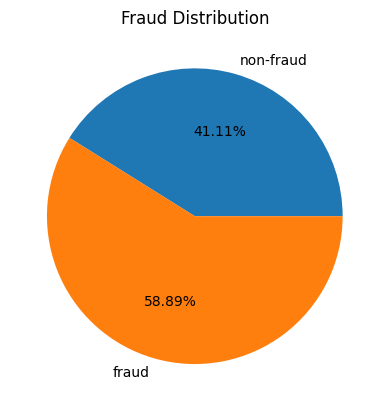

In [ ]:
target = loan_df['isFraud'].value_counts().sort_values()
plt.pie(target, labels=['non-fraud', 'fraud'], autopct='%1.2f%%')
plt.title('Fraud Distribution')
plt.show()

## features analysis and encoding

In [ ]:
loan_df.columns

Index(['loanId', 'anon_ssn', 'payFrequency', 'apr', 'applicationDate',
       'nPaidOff', 'loanStatus', 'loanAmount',
       'originallyScheduledPaymentAmount', 'state', 'leadType', 'leadCost',
       'clarityFraudId', 'hasCF', 'isFraud'],
      dtype='object')

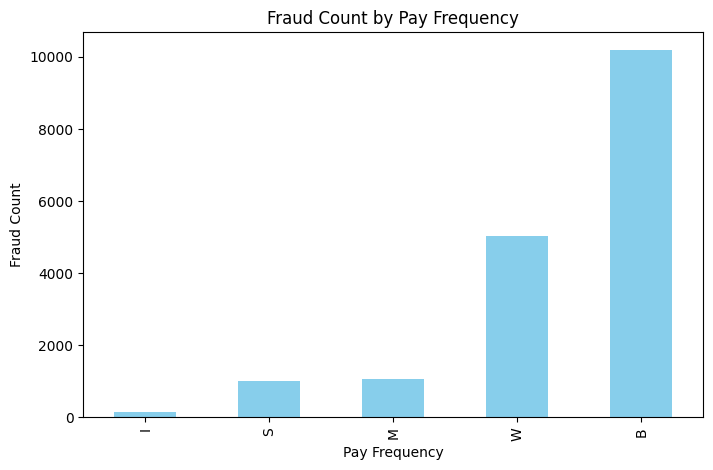

In [ ]:
loan_df.groupby('payFrequency')['isFraud'].sum().sort_values().plot(kind='bar', figsize=(8,5), color='skyblue')
plt.title('Fraud Count by Pay Frequency')
plt.xlabel('Pay Frequency')
plt.ylabel('Fraud Count')
plt.show()


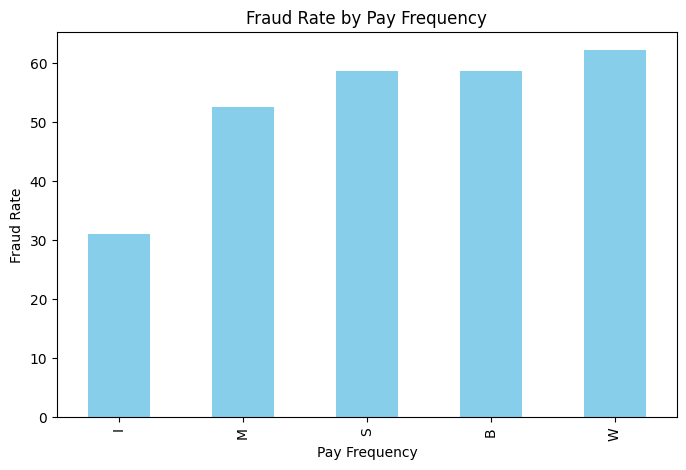

In [ ]:
fraud_rate = loan_df.groupby('payFrequency')['isFraud'].mean().sort_values() *100
fraud_rate.plot(kind='bar', figsize=(8,5), color='skyblue')
plt.title('Fraud Rate by Pay Frequency')
plt.xlabel('Pay Frequency')
plt.ylabel('Fraud Rate')
plt.show()

**Altrough the fraud count show significantly the biweekly pay frequency is most fraud loan amount, but the total of frauds are relative to total of loans.**<br>
**The fraud rate bar chart showing the mean rather than sum, showing the fraud rate equity. It tell that the fraud rate for irragulary is the lowest.**

In [ ]:
pay_freq_encoded = pd.get_dummies(loan_df['payFrequency'], prefix='payFreq_').astype(int)
loan_df = pd.concat([loan_df, pay_freq_encoded], axis=1)
loan_df = loan_df.drop('payFrequency', axis=1)
loan_df.head()

,loanId,anon_ssn,apr,applicationDate,nPaidOff,loanStatus,loanAmount,originallyScheduledPaymentAmount,state,leadType,leadCost,clarityFraudId,hasCF,isFraud,payFreq__B,payFreq__I,payFreq__M,payFreq__S,payFreq__W
1,LL-I-06644937,464f5d9ae4fa09ece4048d949191865c,199.0,2016-01-19 22:07:36.778,0.0,Paid Off Loan,3000.0,6395.19,CA,prescreen,0,569eb3a3e4b096699f685d64,1,0,1,0,0,0,0
47,LL-I-16519347,bc9fa73468acf18cb968a3a6a3c4697c,490.0,2017-01-31 17:48:17.381,2.0,Paid Off Loan,1250.0,3313.78,MO,organic,0,58450a15e4b0bb9d6d7344c7,1,0,0,0,0,1,0
54,LL-I-11506719,10cefd11d41612b032fd9cd2debe32dc,590.0,2016-08-27 09:08:05.442,0.0,Paid Off Loan,800.0,2432.08,CA,bvMandatory,10,578f9346e4b0810ad5e7b72e,1,0,1,0,0,0,0
64,LL-I-09279047,1d249e27292d25e4d3b4bc142a2a4aea,404.1,2016-05-25 03:05:18.849,3.0,Paid Off Loan,300.0,422.64,WI,organic,0,56621584e4b0100e84141586,1,0,0,0,0,0,1
83,LL-I-18297678,bc500677542783c43842d54e34830f08,315.0,2017-03-12 18:24:46.356,2.0,Internal Collection,1500.0,2875.27,IL,organic,0,579101e7e4b0810ad80e43aa,1,1,1,0,0,0,0


**one-hoc encoding for payment frequency, because numerical encoding may effect the model results**

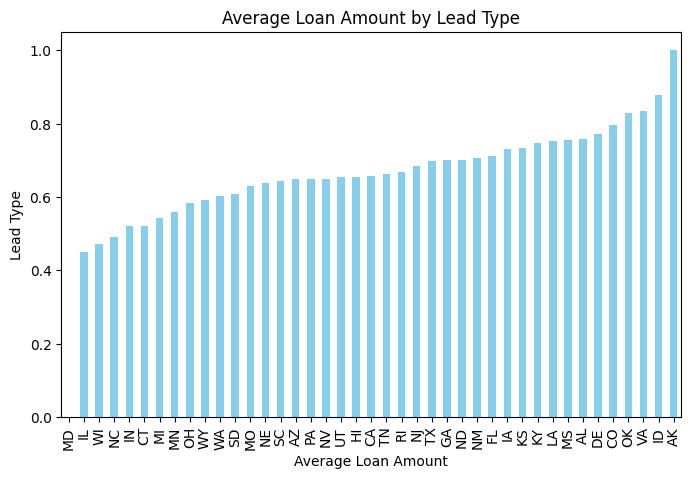

In [ ]:
loan_df.groupby('state')['isFraud'].mean().sort_values().plot(kind='bar', figsize=(8,5), color='skyblue')
plt.title('Average Loan Amount by Lead Type')
plt.xlabel('Average Loan Amount')
plt.ylabel('Lead Type')
plt.show()

In [ ]:
loan_df['state'].nunique()

41

In [ ]:
fraud_of_state = loan_df.groupby('state')['isFraud'].sum().reset_index(name='fraud_count').sort_index()
total_loan_of_state = loan_df.groupby('state')['isFraud'].count().reset_index(name='total_loan_count').sort_index()
fraud_rate_of_state = pd.merge(fraud_of_state, total_loan_of_state, on='state')
fraud_rate_of_state['fraud_rate_of_state'] = fraud_rate_of_state['fraud_count'] / fraud_rate_of_state['total_loan_count']
loan_df = pd.merge(loan_df, fraud_rate_of_state[['state', 'fraud_rate_of_state']], on=['state'] , how='left')
loan_df.drop(columns=['state'], axis=1, inplace=True)

In [ ]:
loan_df.head()

,loanId,anon_ssn,apr,applicationDate,nPaidOff,loanStatus,loanAmount,originallyScheduledPaymentAmount,leadType,leadCost,clarityFraudId,hasCF,isFraud,payFreq__B,payFreq__I,payFreq__M,payFreq__S,payFreq__W,fraud_rate_of_state
0,LL-I-06644937,464f5d9ae4fa09ece4048d949191865c,199.0,2016-01-19 22:07:36.778,0.0,Paid Off Loan,3000.0,6395.19,prescreen,0,569eb3a3e4b096699f685d64,1,0,1,0,0,0,0,0.655897
1,LL-I-16519347,bc9fa73468acf18cb968a3a6a3c4697c,490.0,2017-01-31 17:48:17.381,2.0,Paid Off Loan,1250.0,3313.78,organic,0,58450a15e4b0bb9d6d7344c7,1,0,0,0,0,1,0,0.628866
2,LL-I-11506719,10cefd11d41612b032fd9cd2debe32dc,590.0,2016-08-27 09:08:05.442,0.0,Paid Off Loan,800.0,2432.08,bvMandatory,10,578f9346e4b0810ad5e7b72e,1,0,1,0,0,0,0,0.655897
3,LL-I-09279047,1d249e27292d25e4d3b4bc142a2a4aea,404.1,2016-05-25 03:05:18.849,3.0,Paid Off Loan,300.0,422.64,organic,0,56621584e4b0100e84141586,1,0,0,0,0,0,1,0.471905
4,LL-I-18297678,bc500677542783c43842d54e34830f08,315.0,2017-03-12 18:24:46.356,2.0,Internal Collection,1500.0,2875.27,organic,0,579101e7e4b0810ad80e43aa,1,1,1,0,0,0,0,0.449559


**the state uniq value is 41, will in crease the dimensionality significanly if perform one-hoc encoding**
<br>**decided to use numerical encoding the state feature by the fraud rate of each state (fraud loan amount for the state / total loans amount for the state)**

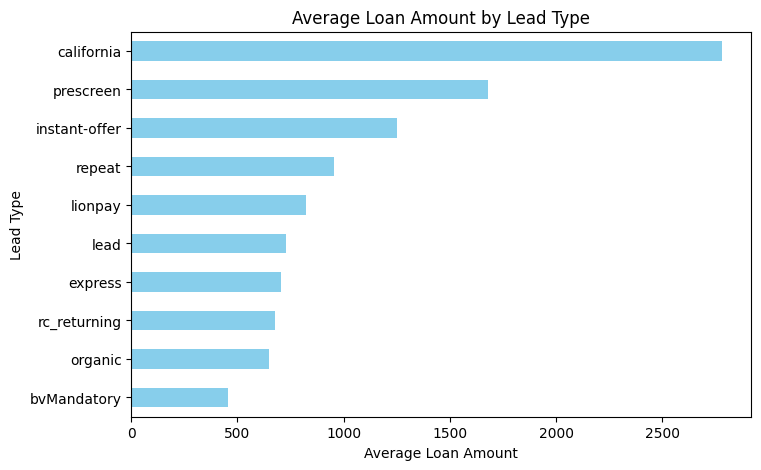

In [ ]:
loan_df.groupby('leadType')['loanAmount'].mean().sort_values().plot(kind='barh', figsize=(8,5), color='skyblue')
plt.title('Average Loan Amount by Lead Type')
plt.xlabel('Average Loan Amount')
plt.ylabel('Lead Type')
plt.show()



**from the bar chart, we know the fraud rate from the state of california is significant higher, and followed by prescreen.**

In [ ]:
lead_type_encoded = pd.get_dummies(loan_df['leadType'], prefix='leadType').astype(int)
loan_df = pd.concat([loan_df, lead_type_encoded], axis=1)
loan_df = loan_df.drop('leadType', axis=1)
loan_df.head()

,loanId,anon_ssn,apr,applicationDate,nPaidOff,loanStatus,loanAmount,originallyScheduledPaymentAmount,leadCost,clarityFraudId,...,leadType_bvMandatory,leadType_california,leadType_express,leadType_instant-offer,leadType_lead,leadType_lionpay,leadType_organic,leadType_prescreen,leadType_rc_returning,leadType_repeat
0,LL-I-06644937,464f5d9ae4fa09ece4048d949191865c,199.0,2016-01-19 22:07:36.778,0.0,Paid Off Loan,3000.0,6395.19,0,569eb3a3e4b096699f685d64,...,0,0,0,0,0,0,0,1,0,0
1,LL-I-16519347,bc9fa73468acf18cb968a3a6a3c4697c,490.0,2017-01-31 17:48:17.381,2.0,Paid Off Loan,1250.0,3313.78,0,58450a15e4b0bb9d6d7344c7,...,0,0,0,0,0,0,1,0,0,0
2,LL-I-11506719,10cefd11d41612b032fd9cd2debe32dc,590.0,2016-08-27 09:08:05.442,0.0,Paid Off Loan,800.0,2432.08,10,578f9346e4b0810ad5e7b72e,...,1,0,0,0,0,0,0,0,0,0
3,LL-I-09279047,1d249e27292d25e4d3b4bc142a2a4aea,404.1,2016-05-25 03:05:18.849,3.0,Paid Off Loan,300.0,422.64,0,56621584e4b0100e84141586,...,0,0,0,0,0,0,1,0,0,0
4,LL-I-18297678,bc500677542783c43842d54e34830f08,315.0,2017-03-12 18:24:46.356,2.0,Internal Collection,1500.0,2875.27,0,579101e7e4b0810ad80e43aa,...,0,0,0,0,0,0,1,0,0,0


**perform one-hoc encoding for leadType**

In [ ]:
loan_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29518 entries, 0 to 29517
Data columns (total 28 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   loanId                            29518 non-null  object        
 1   anon_ssn                          29518 non-null  object        
 2   apr                               29518 non-null  float64       
 3   applicationDate                   29518 non-null  datetime64[ns]
 4   nPaidOff                          29518 non-null  float64       
 5   loanStatus                        29518 non-null  object        
 6   loanAmount                        29518 non-null  float64       
 7   originallyScheduledPaymentAmount  29518 non-null  float64       
 8   leadCost                          29518 non-null  int64         
 9   clarityFraudId                    24521 non-null  object        
 10  hasCF                             29518 non-nu

#Payment Dataset Preprocess

In [ ]:
payment_df.head()

,loanId,installmentIndex,isCollection,paymentDate,principal,fees,paymentAmount,paymentStatus,paymentReturnCode
0,LL-I-00000021,1,False,2014-12-19T05:00:00,22.33,147.28,169.61,Checked,NaN
1,LL-I-00000021,2,False,2015-01-02T05:00:00,26.44,143.17,169.61,Checked,NaN
2,LL-I-00000021,3,False,2015-01-16T05:00:00,31.30,138.31,169.61,Checked,NaN
3,LL-I-00000021,4,False,2015-01-30T05:00:00,37.07,132.54,169.61,Checked,NaN
4,LL-I-00000021,5,False,2015-02-13T05:00:00,43.89,125.72,169.61,Checked,NaN


In [ ]:
payment_df.columns

Index(['loanId', 'installmentIndex', 'isCollection', 'paymentDate',
       'principal', 'fees', 'paymentAmount', 'paymentStatus',
       'paymentReturnCode'],
      dtype='object')

**i choose to not use the payment dataset, because new applicants will not have any payment history. If including the past payment history of customers, may cause unfair prediction between repeated and new customers, and also not accurate to predict new customers loan.**

# Underwriting data preprocess

In [ ]:
underwriting_df.shape

(49752, 54)

In [ ]:
underwriting_df.head()

,.underwritingdataclarity.clearfraud.clearfraudinquiry.thirtydaysago,.underwritingdataclarity.clearfraud.clearfraudinquiry.twentyfourhoursago,.underwritingdataclarity.clearfraud.clearfraudinquiry.oneminuteago,.underwritingdataclarity.clearfraud.clearfraudinquiry.onehourago,.underwritingdataclarity.clearfraud.clearfraudinquiry.ninetydaysago,.underwritingdataclarity.clearfraud.clearfraudinquiry.sevendaysago,.underwritingdataclarity.clearfraud.clearfraudinquiry.tenminutesago,.underwritingdataclarity.clearfraud.clearfraudinquiry.fifteendaysago,.underwritingdataclarity.clearfraud.clearfraudinquiry.threesixtyfivedaysago,.underwritingdataclarity.clearfraud.clearfraudindicator.inquiryonfilecurrentaddressconflict,...,.underwritingdataclarity.clearfraud.clearfraudidentityverification.phonematchtypedescription,.underwritingdataclarity.clearfraud.clearfraudidentityverification.overallmatchresult,.underwritingdataclarity.clearfraud.clearfraudidentityverification.phonetype,.underwritingdataclarity.clearfraud.clearfraudidentityverification.ssndobreasoncode,.underwritingdataclarity.clearfraud.clearfraudidentityverification.ssnnamereasoncode,.underwritingdataclarity.clearfraud.clearfraudidentityverification.nameaddressreasoncode,.underwritingdataclarity.clearfraud.clearfraudidentityverification.ssndobmatch,.underwritingdataclarity.clearfraud.clearfraudidentityverification.overallmatchreasoncode,clearfraudscore,underwritingid
0,8.0,2.0,2.0,2.0,8.0,2.0,2.0,5.0,10.0,False,...,(M) Mobile Phone,partial,NaN,NaN,NaN,A8,match,6.0,871.0,54cbffcee4b0ba763e43144d
1,5.0,2.0,2.0,2.0,11.0,2.0,2.0,4.0,21.0,True,...,(M) Mobile Phone,partial,NaN,NaN,NaN,NaN,match,11.0,397.0,54cc0408e4b0418d9a7f78af
2,9.0,4.0,2.0,3.0,10.0,8.0,2.0,9.0,25.0,False,...,(M) Mobile Phone,match,NaN,NaN,NaN,NaN,match,1.0,572.0,54cc0683e4b0418d9a80adb6
3,3.0,2.0,2.0,2.0,9.0,2.0,2.0,2.0,9.0,False,...,(M) Mobile Phone,partial,NaN,NaN,NaN,NaN,match,11.0,838.0,54cc0780e4b0ba763e43b74a
4,5.0,5.0,2.0,2.0,6.0,5.0,2.0,5.0,6.0,False,...,(M) Mobile Phone,match,NaN,NaN,NaN,NaN,match,1.0,768.0,54cc1d67e4b0ba763e445b45


## increase naming clarity

In [ ]:
underwriting_df.columns

Index(['.underwritingdataclarity.clearfraud.clearfraudinquiry.thirtydaysago',
       '.underwritingdataclarity.clearfraud.clearfraudinquiry.twentyfourhoursago',
       '.underwritingdataclarity.clearfraud.clearfraudinquiry.oneminuteago',
       '.underwritingdataclarity.clearfraud.clearfraudinquiry.onehourago',
       '.underwritingdataclarity.clearfraud.clearfraudinquiry.ninetydaysago',
       '.underwritingdataclarity.clearfraud.clearfraudinquiry.sevendaysago',
       '.underwritingdataclarity.clearfraud.clearfraudinquiry.tenminutesago',
       '.underwritingdataclarity.clearfraud.clearfraudinquiry.fifteendaysago',
       '.underwritingdataclarity.clearfraud.clearfraudinquiry.threesixtyfivedaysago',
       '.underwritingdataclarity.clearfraud.clearfraudindicator.inquiryonfilecurrentaddressconflict',
       '.underwritingdataclarity.clearfraud.clearfraudindicator.totalnumberoffraudindicators',
       '.underwritingdataclarity.clearfraud.clearfraudindicator.telephonenumberinconsistentw

**The variables name are too long, difficult to reviews. we remove the prefix of the variables to look clean.**

In [ ]:
prefix = ".underwritingdataclarity.clearfraud.clearfraud"
underwriting_df.columns = [col.replace(prefix, "") for col in underwriting_df.columns]
underwriting_df.columns

Index(['inquiry.thirtydaysago', 'inquiry.twentyfourhoursago',
       'inquiry.oneminuteago', 'inquiry.onehourago', 'inquiry.ninetydaysago',
       'inquiry.sevendaysago', 'inquiry.tenminutesago',
       'inquiry.fifteendaysago', 'inquiry.threesixtyfivedaysago',
       'indicator.inquiryonfilecurrentaddressconflict',
       'indicator.totalnumberoffraudindicators',
       'indicator.telephonenumberinconsistentwithaddress',
       'indicator.inquiryageyoungerthanssnissuedate',
       'indicator.onfileaddresscautious',
       'indicator.inquiryaddressnonresidential',
       'indicator.onfileaddresshighrisk',
       'indicator.ssnreportedmorefrequentlyforanother',
       'indicator.currentaddressreportedbytradeopenlt90days',
       'indicator.inputssninvalid',
       'indicator.inputssnissuedatecannotbeverified',
       'indicator.inquiryaddresscautious',
       'indicator.morethan3inquiriesinthelast30days',
       'indicator.onfileaddressnonresidential',
       'indicator.creditestablishe

## Underwriting Feature selection

**we only take the clear fraud score since it is the precalculated score from the all inquiry, indicator, and indentity verification variables.**

In [ ]:
underwriting_df = underwriting_df[['underwritingid', 'clearfraudscore']]
underwriting_df.head()

,underwritingid,clearfraudscore
0,54cbffcee4b0ba763e43144d,871.0
1,54cc0408e4b0418d9a7f78af,397.0
2,54cc0683e4b0418d9a80adb6,572.0
3,54cc0780e4b0ba763e43b74a,838.0
4,54cc1d67e4b0ba763e445b45,768.0


# Combine dataset

In [ ]:
combined_df = pd.merge(loan_df, underwriting_df, how='left', left_on='clarityFraudId' , right_on='underwritingid')
combined_df.head()

,loanId,anon_ssn,apr,applicationDate,nPaidOff,loanStatus,loanAmount,originallyScheduledPaymentAmount,leadCost,clarityFraudId,...,leadType_express,leadType_instant-offer,leadType_lead,leadType_lionpay,leadType_organic,leadType_prescreen,leadType_rc_returning,leadType_repeat,underwritingid,clearfraudscore
0,LL-I-06644937,464f5d9ae4fa09ece4048d949191865c,199.0,2016-01-19 22:07:36.778,0.0,Paid Off Loan,3000.0,6395.19,0,569eb3a3e4b096699f685d64,...,0,0,0,0,0,1,0,0,569eb3a3e4b096699f685d64,879.0
1,LL-I-16519347,bc9fa73468acf18cb968a3a6a3c4697c,490.0,2017-01-31 17:48:17.381,2.0,Paid Off Loan,1250.0,3313.78,0,58450a15e4b0bb9d6d7344c7,...,0,0,0,0,1,0,0,0,58450a15e4b0bb9d6d7344c7,835.0
2,LL-I-11506719,10cefd11d41612b032fd9cd2debe32dc,590.0,2016-08-27 09:08:05.442,0.0,Paid Off Loan,800.0,2432.08,10,578f9346e4b0810ad5e7b72e,...,0,0,0,0,0,0,0,0,578f9346e4b0810ad5e7b72e,624.0
3,LL-I-09279047,1d249e27292d25e4d3b4bc142a2a4aea,404.1,2016-05-25 03:05:18.849,3.0,Paid Off Loan,300.0,422.64,0,56621584e4b0100e84141586,...,0,0,0,0,1,0,0,0,56621584e4b0100e84141586,770.0
4,LL-I-18297678,bc500677542783c43842d54e34830f08,315.0,2017-03-12 18:24:46.356,2.0,Internal Collection,1500.0,2875.27,0,579101e7e4b0810ad80e43aa,...,0,0,0,0,1,0,0,0,579101e7e4b0810ad80e43aa,932.0


In [ ]:
print(combined_df.isnull().sum())

loanId                                 0
anon_ssn                               0
apr                                    0
applicationDate                        0
nPaidOff                               0
loanStatus                             0
loanAmount                             0
originallyScheduledPaymentAmount       0
leadCost                               0
clarityFraudId                      4997
hasCF                                  0
isFraud                                0
payFreq__B                             0
payFreq__I                             0
payFreq__M                             0
payFreq__S                             0
payFreq__W                             0
fraud_rate_of_state                    0
leadType_bvMandatory                   0
leadType_california                    0
leadType_express                       0
leadType_instant-offer                 0
leadType_lead                          0
leadType_lionpay                       0
leadType_organic

**there are 5116 values are missing at clearfraudscore, we try to find the variables that have relationship with clearfraudscore to do computation.**

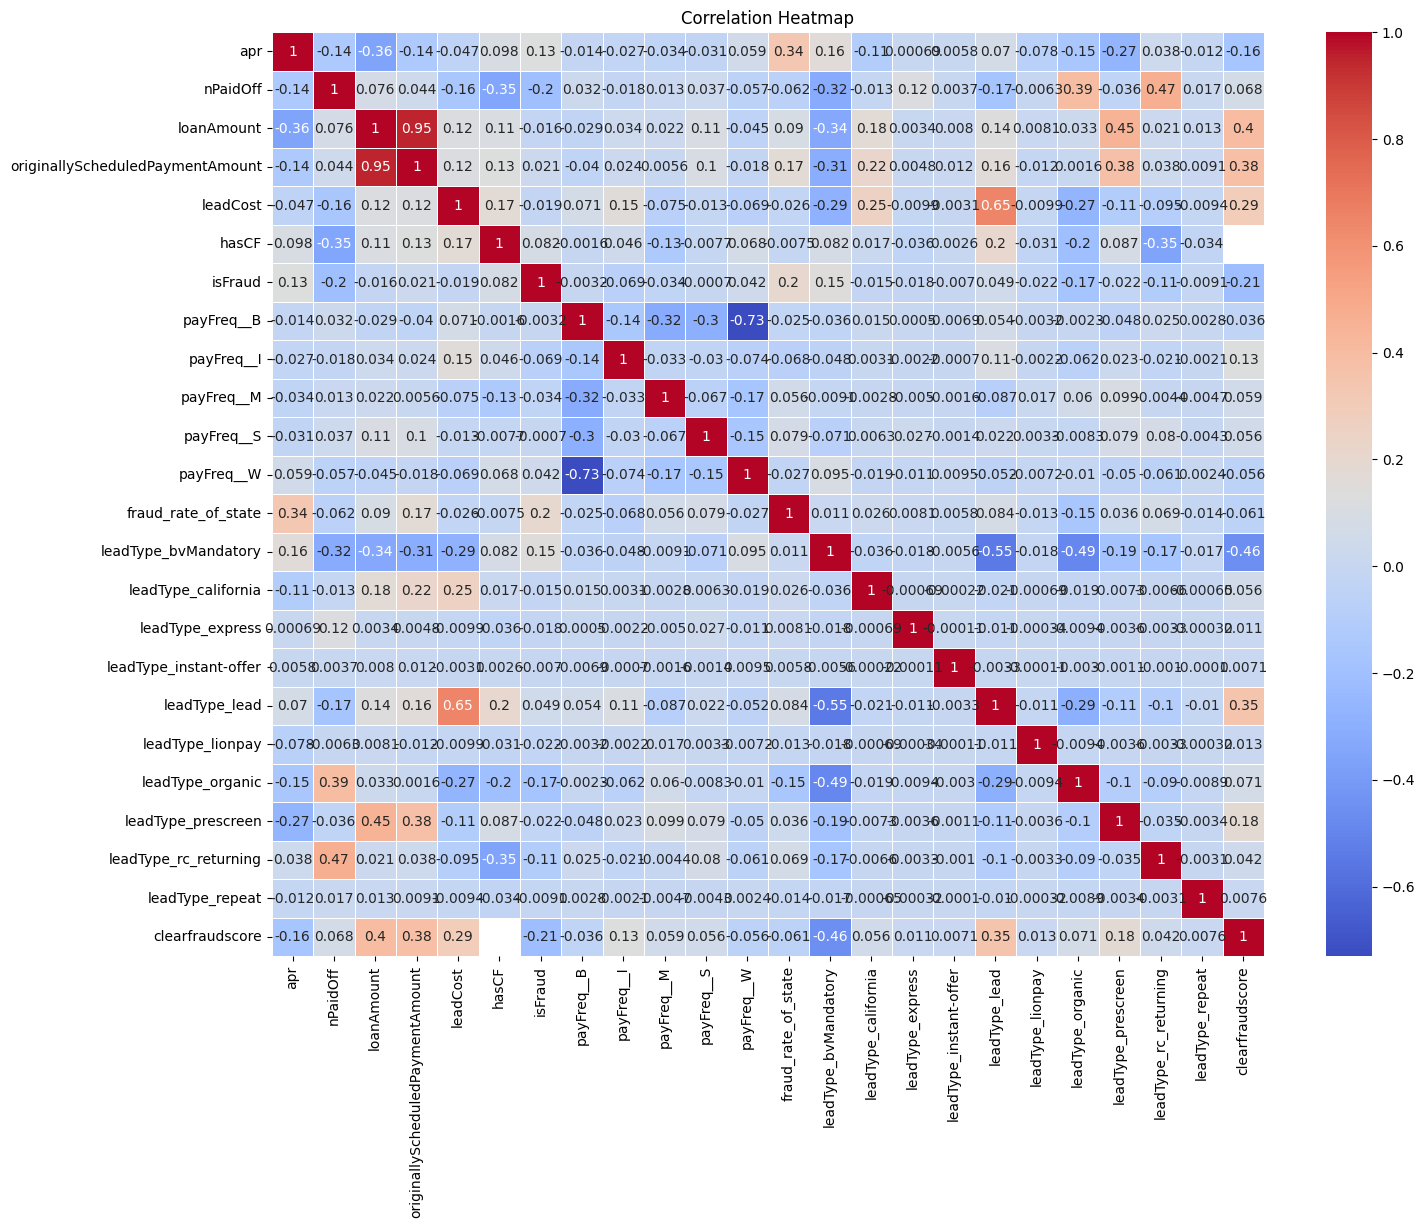

In [ ]:
numeric_df = combined_df.select_dtypes(include=['int64', 'float64'])
plt.figure(figsize=(16,12))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

**for numerical variable, only loanAmount, orriginallyScheduledPaymentAmount, and leadCost are showing relationship.**

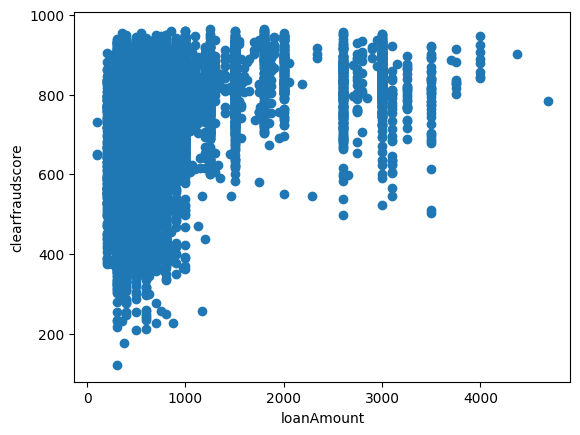

In [ ]:
plt.scatter(combined_df['loanAmount'], combined_df['clearfraudscore'])
plt.xlabel('loanAmount')
plt.ylabel('clearfraudscore')
plt.show()

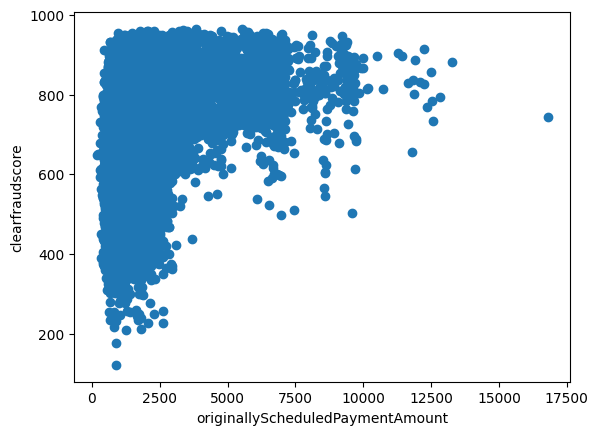

In [ ]:
plt.scatter(combined_df['originallyScheduledPaymentAmount'], combined_df['clearfraudscore'])
plt.xlabel('originallyScheduledPaymentAmount')
plt.ylabel('clearfraudscore')
plt.show()

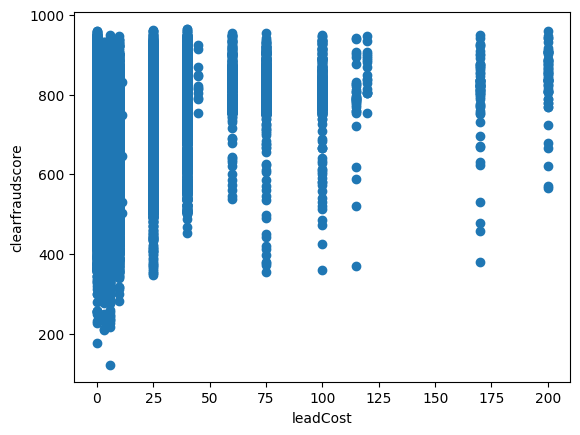

In [ ]:
plt.scatter(combined_df['leadCost'], combined_df['clearfraudscore'])
plt.xlabel('leadCost')
plt.ylabel('clearfraudscore')
plt.show()

**non linear relationship, we use KNN to compute the clear fraud score of those missing values.**

In [ ]:
#training data preparation
fraud_score_df = combined_df[['clearfraudscore', 'leadCost', 'originallyScheduledPaymentAmount', 'loanAmount']]
train = fraud_score_df.dropna()
train_X = train[['leadCost', 'originallyScheduledPaymentAmount', 'loanAmount']]
train_y = train['clearfraudscore']
test = fraud_score_df[fraud_score_df['clearfraudscore'].isnull()]
test_X = test[['leadCost', 'originallyScheduledPaymentAmount', 'loanAmount']]

In [ ]:
train.shape, test.shape

((24402, 4), (5116, 4))

In [ ]:


scaler = StandardScaler()
train_X_scaled = scaler.fit_transform(train_X)
test_X_scaled = scaler.transform(test_X)

k_values = range(1, 20)
cv_scores = []

for k in k_values:
    knn = KNN(n_neighbors=k, weights='distance')
    score = cross_val_score(knn, train_X_scaled, train_y, cv=5, scoring='neg_mean_squared_error')
    rmse = np.mean(np.sqrt(-score))
    cv_scores.append(rmse)

# Use np.argmin because smaller RMSE is better
best_k = k_values[np.argmin(cv_scores)]
print("Best k:", best_k)


Best k: 19


In [ ]:
knn = KNN(n_neighbors=best_k, weights='distance')
knn.fit(train_X_scaled, train_y)
predictions = knn.predict(test_X_scaled)
predictions

array([504.8       , 590.15047   , 733.28840077, ..., 705.12747404,
       518.49166636, 729.01136242])

In [ ]:
# assign prediction value to corresponding null records
null_clearfraudscore_indices = combined_df[combined_df['clearfraudscore'].isnull()].index
combined_df.loc[null_clearfraudscore_indices, 'clearfraudscore'] = predictions
combined_df.head()

,loanId,anon_ssn,apr,applicationDate,nPaidOff,loanStatus,loanAmount,originallyScheduledPaymentAmount,leadCost,clarityFraudId,...,leadType_express,leadType_instant-offer,leadType_lead,leadType_lionpay,leadType_organic,leadType_prescreen,leadType_rc_returning,leadType_repeat,underwritingid,clearfraudscore
0,LL-I-06644937,464f5d9ae4fa09ece4048d949191865c,199.0,2016-01-19 22:07:36.778,0.0,Paid Off Loan,3000.0,6395.19,0,569eb3a3e4b096699f685d64,...,0,0,0,0,0,1,0,0,569eb3a3e4b096699f685d64,879.0
1,LL-I-16519347,bc9fa73468acf18cb968a3a6a3c4697c,490.0,2017-01-31 17:48:17.381,2.0,Paid Off Loan,1250.0,3313.78,0,58450a15e4b0bb9d6d7344c7,...,0,0,0,0,1,0,0,0,58450a15e4b0bb9d6d7344c7,835.0
2,LL-I-11506719,10cefd11d41612b032fd9cd2debe32dc,590.0,2016-08-27 09:08:05.442,0.0,Paid Off Loan,800.0,2432.08,10,578f9346e4b0810ad5e7b72e,...,0,0,0,0,0,0,0,0,578f9346e4b0810ad5e7b72e,624.0
3,LL-I-09279047,1d249e27292d25e4d3b4bc142a2a4aea,404.1,2016-05-25 03:05:18.849,3.0,Paid Off Loan,300.0,422.64,0,56621584e4b0100e84141586,...,0,0,0,0,1,0,0,0,56621584e4b0100e84141586,770.0
4,LL-I-18297678,bc500677542783c43842d54e34830f08,315.0,2017-03-12 18:24:46.356,2.0,Internal Collection,1500.0,2875.27,0,579101e7e4b0810ad80e43aa,...,0,0,0,0,1,0,0,0,579101e7e4b0810ad80e43aa,932.0


In [ ]:
print(combined_df.isnull().sum())

loanId                                 0
anon_ssn                               0
apr                                    0
applicationDate                        0
nPaidOff                               0
loanStatus                             0
loanAmount                             0
originallyScheduledPaymentAmount       0
leadCost                               0
clarityFraudId                      4997
hasCF                                  0
isFraud                                0
payFreq__B                             0
payFreq__I                             0
payFreq__M                             0
payFreq__S                             0
payFreq__W                             0
fraud_rate_of_state                    0
leadType_bvMandatory                   0
leadType_california                    0
leadType_express                       0
leadType_instant-offer                 0
leadType_lead                          0
leadType_lionpay                       0
leadType_organic

**all missing values are filled**

##Feature engineering

### construct past loan count
**we compute past loan count for model to categories new user vesus repeat user. So the features like nPaidOff of new customer is 0 is make sense (not bais)**

In [ ]:
combined_df['applicationDate'] = pd.to_datetime(combined_df['applicationDate'])
combined_df = combined_df.sort_values(['anon_ssn', 'applicationDate'], ascending=[True, True])
combined_df['all_one_for_loan_count'] = 1
combined_df['past_loan_count'] = combined_df.groupby('anon_ssn')['all_one_for_loan_count'].cumsum()
combined_df['past_loan_count'] = combined_df['past_loan_count'] - 1
combined_df.drop(columns=['all_one_for_loan_count'], inplace=True)
combined_df.head()

,loanId,anon_ssn,apr,applicationDate,nPaidOff,loanStatus,loanAmount,originallyScheduledPaymentAmount,leadCost,clarityFraudId,...,leadType_instant-offer,leadType_lead,leadType_lionpay,leadType_organic,leadType_prescreen,leadType_rc_returning,leadType_repeat,underwritingid,clearfraudscore,past_loan_count
20400,LL-I-13612582,00006b47f484731c95b4c11a42f9c2e3,645.0,2016-12-21 02:57:57.321,0.0,Paid Off Loan,500.0,1728.52,10,5859efb2e4b08f2464d27565,...,0,1,0,0,0,0,0,5859efb2e4b08f2464d27565,736.0,0
12904,LL-I-10308424,00069c6c4fa5fa1b94b845ffde8e081b,360.0,2016-07-15 20:19:00.936,0.0,Paid Off Loan,300.0,670.49,3,5789451ee4b0022658b51b71,...,0,0,0,0,0,0,0,5789451ee4b0022658b51b71,545.0,0
17406,LL-I-06339246,00094b88d7a7caea540dd3c77fe1ff9c,601.0,2016-01-08 18:08:58.183,0.0,External Collection,600.0,1830.29,6,568ffc68e4b08fd46921c6e2,...,0,0,0,0,0,0,0,568ffc68e4b08fd46921c6e2,710.0,0
23488,LL-I-12250877,000c0aa9b221e0ca8bb76dfd55d3847c,590.0,2016-11-28 15:14:54.192,1.0,Paid Off Loan,600.0,1699.35,0,57bb579be4b033e6e44d7011,...,0,0,0,0,0,1,0,57bb579be4b033e6e44d7011,872.0,0
19681,LL-I-13429398,000e7188ab65dde1f6a8a576f28d8d24,645.0,2016-12-18 17:22:29.910,0.0,Internal Collection,600.0,1958.20,6,5856c5d3e4b08f2460bef12a,...,0,1,0,0,0,0,0,5856c5d3e4b08f2460bef12a,782.0,0


In [ ]:
combined_df['past_loan_count'].describe()

,past_loan_count
count,29518.000000
mean,0.151060
std,0.492152
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,11.000000


**the 75% th is 0 means most of the loans are from new customers**

###**construct past paid off loan amount**

In [ ]:
combined_df['is_paid_off'] = combined_df['loanStatus'].str.contains('Paid Off').astype(int)
combined_df['paid_off_loan_amount'] = combined_df['loanAmount'] * combined_df['is_paid_off']

combined_df = combined_df.sort_values(['anon_ssn', 'applicationDate'], ascending=[True, True])
combined_df['past_paid_off_loan_amount'] = combined_df.groupby('anon_ssn')['paid_off_loan_amount'].cumsum()
combined_df['past_paid_off_loan_amount'] = combined_df['past_paid_off_loan_amount'] - combined_df['paid_off_loan_amount']
combined_df['past_paid_off_loan_amount'].fillna(0)
combined_df.drop(columns=['paid_off_loan_amount'], inplace = True)
combined_df.head(10)

,loanId,anon_ssn,apr,applicationDate,nPaidOff,loanStatus,loanAmount,originallyScheduledPaymentAmount,leadCost,clarityFraudId,...,leadType_lionpay,leadType_organic,leadType_prescreen,leadType_rc_returning,leadType_repeat,underwritingid,clearfraudscore,past_loan_count,is_paid_off,past_paid_off_loan_amount
20400,LL-I-13612582,00006b47f484731c95b4c11a42f9c2e3,645.00,2016-12-21 02:57:57.321,0.0,Paid Off Loan,500.0,1728.52,10,5859efb2e4b08f2464d27565,...,0,0,0,0,0,5859efb2e4b08f2464d27565,736.0,0,1,0.0
12904,LL-I-10308424,00069c6c4fa5fa1b94b845ffde8e081b,360.00,2016-07-15 20:19:00.936,0.0,Paid Off Loan,300.0,670.49,3,5789451ee4b0022658b51b71,...,0,0,0,0,0,5789451ee4b0022658b51b71,545.0,0,1,0.0
17406,LL-I-06339246,00094b88d7a7caea540dd3c77fe1ff9c,601.00,2016-01-08 18:08:58.183,0.0,External Collection,600.0,1830.29,6,568ffc68e4b08fd46921c6e2,...,0,0,0,0,0,568ffc68e4b08fd46921c6e2,710.0,0,0,0.0
23488,LL-I-12250877,000c0aa9b221e0ca8bb76dfd55d3847c,590.00,2016-11-28 15:14:54.192,1.0,Paid Off Loan,600.0,1699.35,0,57bb579be4b033e6e44d7011,...,0,0,0,1,0,57bb579be4b033e6e44d7011,872.0,0,1,0.0
19681,LL-I-13429398,000e7188ab65dde1f6a8a576f28d8d24,645.00,2016-12-18 17:22:29.910,0.0,Internal Collection,600.0,1958.20,6,5856c5d3e4b08f2460bef12a,...,0,0,0,0,0,5856c5d3e4b08f2460bef12a,782.0,0,0,0.0
8047,LL-I-14894567,000edb0725f9806280727fbff1099655,645.00,2017-01-11 23:45:17.679,0.0,Internal Collection,700.0,1629.79,10,5876c38ae4b08f247e8fc4f0,...,0,0,0,0,0,5876c38ae4b08f247e8fc4f0,783.0,0,0,0.0
18837,LL-I-10185112,001589271175754efc9643fd2d4b654b,501.50,2016-07-07 10:40:53.581,1.0,External Collection,1000.0,2667.64,0,569170a2e4b040f8b643776d,...,0,1,0,0,0,569170a2e4b040f8b643776d,705.0,0,0,0.0
10617,LL-I-09394172,00166d34c1276616154d830a9ef2f620,590.00,2016-05-30 19:58:51.102,0.0,Paid Off Loan,700.0,2040.27,10,574c9d54e4b080abc7135d07,...,0,0,0,0,0,574c9d54e4b080abc7135d07,708.0,0,1,0.0
16665,LL-I-05743901,0019a85f11c8d85805ea90b4deb461a4,360.00,2015-12-15 14:55:26.232,0.0,Paid Off Loan,500.0,996.44,6,56702b32e4b08b75784f09f7,...,0,0,0,0,0,56702b32e4b08b75784f09f7,818.0,0,1,0.0
7233,LL-I-04017590,001d0e7cf729ab5745fde809ab4dae44,449.99,2015-10-23 17:38:56.565,0.0,Paid Off Loan,700.0,1254.26,75,562a7076e4b0b681bc5967b3,...,0,0,0,0,0,562a7076e4b0b681bc5967b3,905.0,0,1,0.0


### construst past fraud count

In [ ]:
combined_df['past_is_fraud_count'] = combined_df.groupby('anon_ssn')['isFraud'].cumsum()
combined_df['past_is_fraud_count'] = combined_df['past_is_fraud_count'] - combined_df['isFraud']
combined_df

,loanId,anon_ssn,apr,applicationDate,nPaidOff,loanStatus,loanAmount,originallyScheduledPaymentAmount,leadCost,clarityFraudId,...,leadType_organic,leadType_prescreen,leadType_rc_returning,leadType_repeat,underwritingid,clearfraudscore,past_loan_count,is_paid_off,past_paid_off_loan_amount,past_is_fraud_count
20400,LL-I-13612582,00006b47f484731c95b4c11a42f9c2e3,645.0,2016-12-21 02:57:57.321,0.0,Paid Off Loan,500.0,1728.52,10,5859efb2e4b08f2464d27565,...,0,0,0,0,5859efb2e4b08f2464d27565,736.0,0,1,0.0,0
12904,LL-I-10308424,00069c6c4fa5fa1b94b845ffde8e081b,360.0,2016-07-15 20:19:00.936,0.0,Paid Off Loan,300.0,670.49,3,5789451ee4b0022658b51b71,...,0,0,0,0,5789451ee4b0022658b51b71,545.0,0,1,0.0,0
17406,LL-I-06339246,00094b88d7a7caea540dd3c77fe1ff9c,601.0,2016-01-08 18:08:58.183,0.0,External Collection,600.0,1830.29,6,568ffc68e4b08fd46921c6e2,...,0,0,0,0,568ffc68e4b08fd46921c6e2,710.0,0,0,0.0,0
23488,LL-I-12250877,000c0aa9b221e0ca8bb76dfd55d3847c,590.0,2016-11-28 15:14:54.192,1.0,Paid Off Loan,600.0,1699.35,0,57bb579be4b033e6e44d7011,...,0,0,1,0,57bb579be4b033e6e44d7011,872.0,0,1,0.0,0
19681,LL-I-13429398,000e7188ab65dde1f6a8a576f28d8d24,645.0,2016-12-18 17:22:29.910,0.0,Internal Collection,600.0,1958.20,6,5856c5d3e4b08f2460bef12a,...,0,0,0,0,5856c5d3e4b08f2460bef12a,782.0,0,0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1833,LL-I-04478149,fff55344f76859d9801b747cd1e4544a,360.0,2015-11-10 00:20:13.324,0.0,External Collection,350.0,696.89,6,56413837e4b0f92a540e0d28,...,0,0,0,0,56413837e4b0f92a540e0d28,851.0,0,0,0.0,0
223,LL-I-10007971,fff56ffbfc1f5ccf1c1211e599f11c85,449.0,2016-06-27 14:23:25.349,0.0,External Collection,400.0,572.51,6,5773e365e4b0c54ac986694b,...,0,0,0,0,5773e365e4b0c54ac986694b,401.0,0,0,0.0,0
11081,LL-I-18535621,fffa10032c34c5c03e76b208dc664f70,490.0,2017-03-17 01:48:51.748,0.0,Paid Off Loan,500.0,1299.24,25,58cb4081e4b0b0437c561188,...,0,0,0,0,58cb4081e4b0b0437c561188,766.0,0,1,0.0,0
2418,LL-I-07128889,fffd209b1487bbfa0bac0e0cebdbf3a1,590.0,2016-02-08 22:11:27.593,0.0,External Collection,400.0,1202.35,3,56b91361e4b0044c318f0317,...,0,0,0,0,56b91361e4b0044c318f0317,372.0,0,0,0.0,0


**only 3 records with past fraud, we don't including in modeling becasue not enough to improve model accuracy**

In [ ]:
combined_df.drop(columns=['past_is_fraud_count'], inplace=True)

##**Deal with skewed features**

In [ ]:
combined_df[['loanAmount', 'apr', 'originallyScheduledPaymentAmount', 'leadCost', 'past_paid_off_loan_amount']].describe()

,loanAmount,apr,originallyScheduledPaymentAmount,leadCost,past_paid_off_loan_amount
count,29518.000000,29518.000000,29518.000000,29518.000000,29518.000000
mean,619.451707,528.107006,1691.471815,11.553561,84.977912
std,460.187799,117.386188,1221.403110,21.543094,337.815201
min,100.000000,0.000000,187.620000,0.000000,0.000000
25%,350.000000,449.990000,1010.120000,0.000000,0.000000
50%,500.000000,590.000000,1305.380000,3.000000,0.000000
75%,700.000000,590.000000,1926.180000,10.000000,0.000000
max,4687.000000,705.590000,16800.120000,200.000000,9000.000000


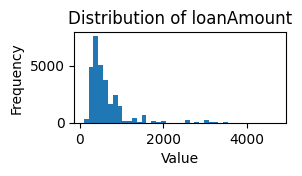

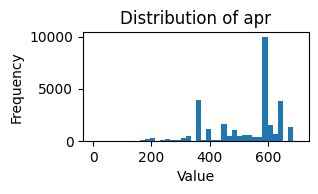

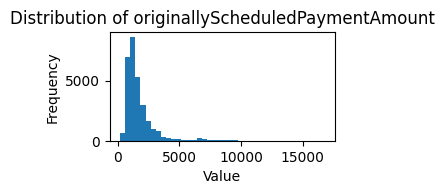

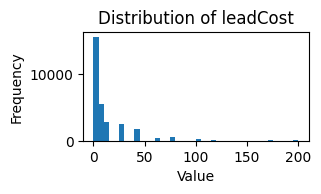

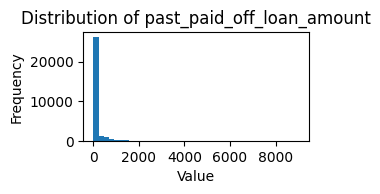

In [ ]:
plt.figure(figsize=(6,4))

plt.subplot(3,2,1)
plt.hist(combined_df['loanAmount'], bins=40)
plt.title('Distribution of loanAmount')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

plt.subplot(3,2,2)
plt.hist(combined_df['apr'], bins=40)
plt.title('Distribution of apr')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

plt.subplot(3,2,3)
plt.hist(combined_df['originallyScheduledPaymentAmount'], bins=40)
plt.title('Distribution of originallyScheduledPaymentAmount')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

plt.subplot(3,2,4)
plt.hist(combined_df['leadCost'], bins=40)
plt.title('Distribution of leadCost')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

plt.subplot(3,2,5)
plt.hist(combined_df['past_paid_off_loan_amount'], bins=40)
plt.title('Distribution of past_paid_off_loan_amount')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()


**loanAmount, scheduledPayment, leadCost, and past_paid_off_loan_amount are skewed right. Using log transform to make them smoother.**

In [ ]:
combined_df['loanAmount_log'] = np.log1p(combined_df['loanAmount'])
combined_df['scheduledPayment_log'] = np.log1p(combined_df['originallyScheduledPaymentAmount'])
combined_df['leadCost_log'] = np.log1p(combined_df['leadCost'])
combined_df['past_paid_off_loan_amount_log'] = np.log1p(combined_df['past_paid_off_loan_amount'])

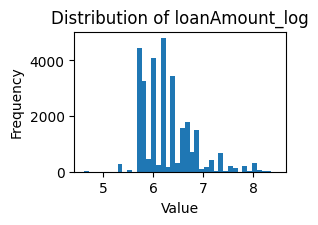

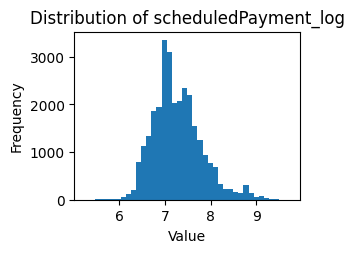

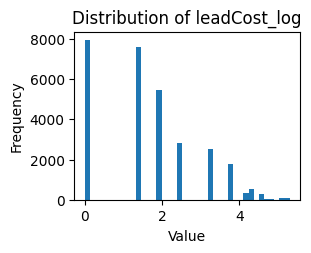

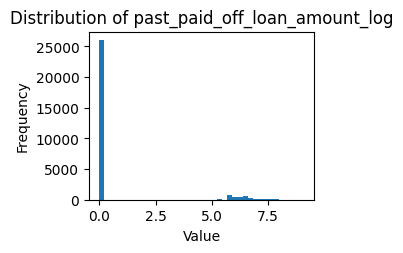

In [ ]:
plt.figure(figsize=(6,4))

plt.subplot(2,2,1)
plt.hist(combined_df['loanAmount_log'], bins=40)
plt.title('Distribution of loanAmount_log')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

plt.subplot(2,2,2)
plt.hist(combined_df['scheduledPayment_log'], bins=40)
plt.title('Distribution of scheduledPayment_log')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

plt.subplot(2,2,3)
plt.hist(combined_df['leadCost_log'], bins=40)
plt.title('Distribution of leadCost_log')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

plt.subplot(2,2,4)
plt.hist(combined_df['past_paid_off_loan_amount_log'], bins=40)
plt.title('Distribution of past_paid_off_loan_amount_log')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()


**now is good**

**Drop no meaning features**

In [ ]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29518 entries, 20400 to 17808
Data columns (total 37 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   loanId                            29518 non-null  object        
 1   anon_ssn                          29518 non-null  object        
 2   apr                               29518 non-null  float64       
 3   applicationDate                   29518 non-null  datetime64[ns]
 4   nPaidOff                          29518 non-null  float64       
 5   loanStatus                        29518 non-null  object        
 6   loanAmount                        29518 non-null  float64       
 7   originallyScheduledPaymentAmount  29518 non-null  float64       
 8   leadCost                          29518 non-null  int64         
 9   clarityFraudId                    24521 non-null  object        
 10  hasCF                             29518 non-nul

#**Final features selection (drop non/less meaning features)**

In [ ]:
combined_df.drop(columns=['loanId', 'anon_ssn', 'applicationDate', 'loanStatus', 'loanAmount',
                      'originallyScheduledPaymentAmount', 'leadCost', 'clarityFraudId',
                      'underwritingid','is_paid_off', 'past_paid_off_loan_amount'], inplace=True)
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29518 entries, 20400 to 17808
Data columns (total 26 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   apr                            29518 non-null  float64
 1   nPaidOff                       29518 non-null  float64
 2   hasCF                          29518 non-null  int64  
 3   isFraud                        29518 non-null  int64  
 4   payFreq__B                     29518 non-null  int64  
 5   payFreq__I                     29518 non-null  int64  
 6   payFreq__M                     29518 non-null  int64  
 7   payFreq__S                     29518 non-null  int64  
 8   payFreq__W                     29518 non-null  int64  
 9   fraud_rate_of_state            29518 non-null  float64
 10  leadType_bvMandatory           29518 non-null  int64  
 11  leadType_california            29518 non-null  int64  
 12  leadType_express               29518 non-null  

In [ ]:
combined_df.to_csv('combined_df.csv', index=False)